The dataset contains information about 200 coffee shops located in 10 cities in Ukraine.

The goal of this project is to perform clustering, using K-Means and Hierarchical Clustering algorithms.

##Data Preprocessing

Importing libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install category_encoders
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Reading dataset, checking info about attributes.

In [2]:
coffee_shops = pd.read_csv('Ukraine Cities Coffee Shops Analysis - Main.csv')

In [3]:
coffee_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


Dropping the attribute "Place name" which seems to be insignificant. Checking data formats of the rest.

In [4]:
coffee_shops = coffee_shops.drop(columns = ["Place name"])
coffee_shops.head()

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Coffee shop,5.0,11.0,NaN,NaN,NaN,True
3,Mariupol,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,Coffee shop,5.0,12.0,NaN,NaN,True,True


Counting amounts of missing values and filling in with mean value for ordinal and numerical attributes, false value for binary ones. Converting ordinal and binary attributes to the numerical form.

In [5]:
coffee_shops.isna().sum()

Region              0
Place type          0
Rating              2
Reviews             2
Price              78
Delivery option    71
Dine in option     60
Takeout option     56
dtype: int64

In [6]:
coffee_shops['Price'].value_counts()

$$     116
$$$      4
$        2
Name: Price, dtype: int64

In [7]:
coffee_shops['Rating'].fillna(coffee_shops['Rating'].mean().round(1), inplace=True)
coffee_shops['Reviews'].fillna(coffee_shops['Reviews'].mean().round(0), inplace=True)
coffee_shops['Price'].fillna('$$', inplace=True)
coffee_shops['Delivery option'].fillna(False, inplace=True)
coffee_shops['Dine in option'].fillna(False, inplace=True)
coffee_shops['Takeout option'].fillna(False, inplace=True)

In [8]:
bool_cols = coffee_shops.iloc[:, 5:].columns
coffee_shops[bool_cols] = coffee_shops[bool_cols].replace({
   True: 1,
   False: 0
})

coffee_shops['Price'] = coffee_shops['Price'].replace({'$':0, '$$':1, '$$$':2})
coffee_shops

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Coffee store,4.6,206.0,1,0,0,0
1,Mariupol,Cafe,5.0,24.0,1,0,0,1
2,Mariupol,Coffee shop,5.0,11.0,1,0,0,1
3,Mariupol,Coffee shop,4.4,331.0,1,0,1,1
4,Mariupol,Coffee shop,5.0,12.0,1,0,1,1
...,...,...,...,...,...,...,...,...
195,Dnipro,Restaurant,4.6,963.0,2,0,1,1
196,Dnipro,Cafe,4.3,646.0,1,0,1,1
197,Dnipro,Cafe,4.6,16.0,1,0,1,1
198,Dnipro,Coffee shop,4.7,599.0,1,0,1,1


In [9]:
coffee_shops.isna().sum()

Region             0
Place type         0
Rating             0
Reviews            0
Price              0
Delivery option    0
Dine in option     0
Takeout option     0
dtype: int64

##Data Exploration

Checking the **amount** of places by **region**.

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<Figure size 792x648 with 0 Axes>

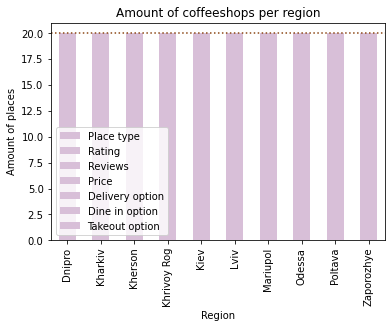

In [10]:
plt.figure(figsize = (11,9))
coffee_shops.groupby('Region').count().plot(kind = 'bar', color = 'thistle', title = 'Amount of coffeeshops per region', cmap = sns.cubehelix_palette(as_cmap = True))
plt.axhline(y = 20, color = 'saddlebrown', linestyle = ':')
plt.xlabel("Region")
plt.ylabel("Amount of places")
plt.show()

Making correlation **heatmap**.

As you can see below, high correlation occurs only between "Takeout option" and "Dine in option" attributes. Still, it doesn't have a huge impact.

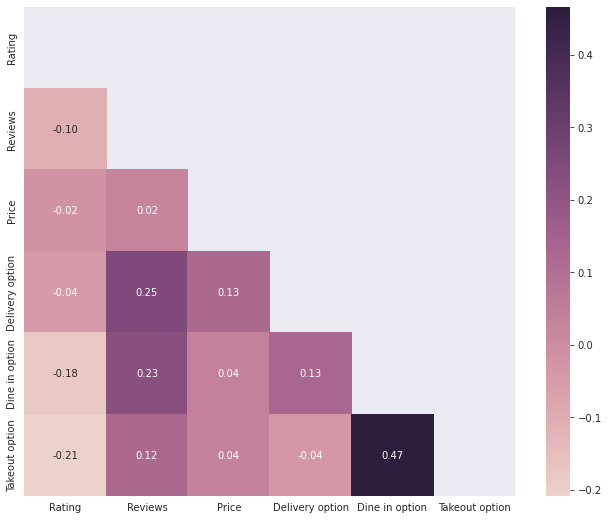

In [11]:
sns.set_style("darkgrid")
corr_w = coffee_shops.corr()
dropSelf = np.zeros_like(corr_w)
dropSelf[np.triu_indices_from(dropSelf)] = True

plt.figure(figsize = (11,9))
sns.heatmap(corr_w, cmap = sns.cubehelix_palette(as_cmap = True), annot = True, fmt = ".2f", mask = dropSelf)

On the plot below, there is a violinplot of **ratings** distribution by **place type**.

It's easy to notice that half of the values are used only once: exactly 7 place types occur just once, and this single value defines the mean value of the distribution, depicted as a vertical line.

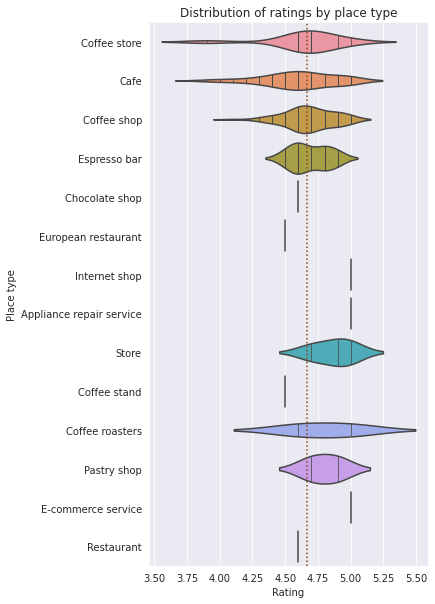

In [12]:
plt.figure(figsize = (5,10))
sns.violinplot(data = coffee_shops, x = "Rating", y = "Place type", inner = "stick")
plt.axvline(x = coffee_shops["Rating"].mean(), color = 'saddlebrown', linestyle = ':')
plt.title('Distribution of ratings by place type')
plt.show()

Below, is a plot that shows the amount of a single place type occurrence.

The majority of records are from coffee shops and cafés.

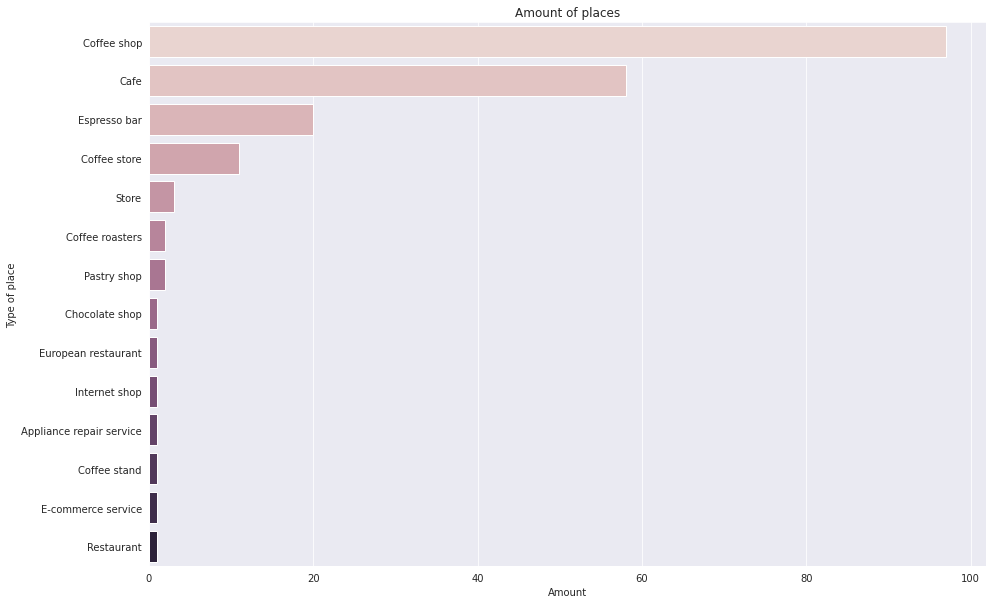

In [13]:
plt.figure(figsize = (15, 10))
places_amount = coffee_shops['Place type'].value_counts()
sns.barplot(x = places_amount.values, y = places_amount.index, order = coffee_shops['Place type'].value_counts().index, palette = sns.cubehelix_palette(14))
plt.xlabel("Amount")
plt.ylabel("Type of place")
plt.title("Amount of places")
plt.show()

Distributions of places with a certain **price range**.

It's noticeable, that the vast majority of places belong to the medium price range (or $$). Important to remember, that 78 of them were NaN values and medium range was assigned manually.

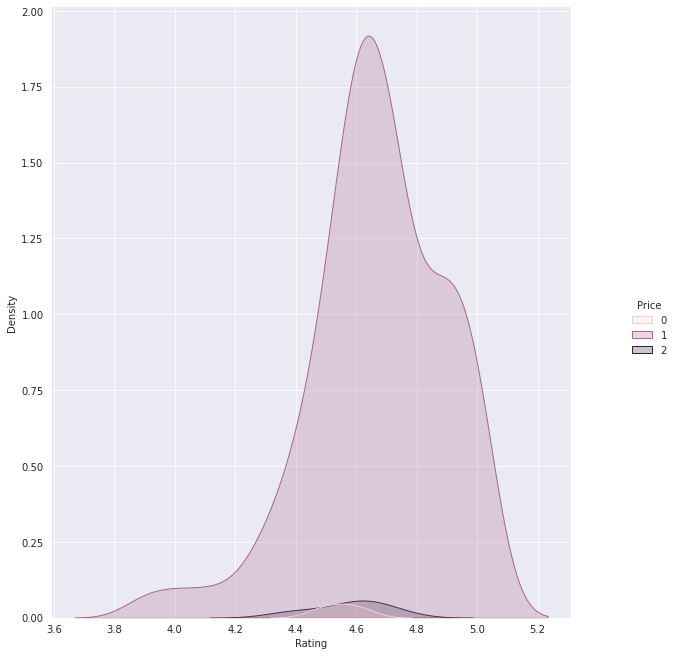

In [14]:
disp = sns.displot(coffee_shops, x = "Rating", hue = "Price", kind = "kde", fill = True)
disp.fig.set_figwidth(10)
disp.fig.set_figheight(10)

##Dimensionality reduction and Clustering

In this project, I will compare the performance of two models: K-means and Hierarchical Clustering.

Starting with creating a copy of the original coffee shop's data frame for further transformations.

In [15]:
cs_transformed = coffee_shops.copy()

I'm going to use Target Encoding to encode categorical values, such as Region and Place type. I chose this particular algorithm because we deal with a wide variety of values.

In [16]:
tenc = ce.TargetEncoder()
regionEncoded = tenc.fit_transform(cs_transformed['Region'], cs_transformed['Rating']).round(1)
placeTypeEncoded = tenc.fit_transform(cs_transformed['Place type'], cs_transformed['Reviews']).round(0)

cs_transformed = placeTypeEncoded.join(cs_transformed.drop('Place type',axis = 1))
cs_transformed = regionEncoded.join(cs_transformed.drop('Region',axis = 1))
cs_transformed

,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,4.7,543.0,4.6,206.0,1,0,0,0
1,4.7,536.0,5.0,24.0,1,0,0,1
2,4.7,736.0,5.0,11.0,1,0,0,1
3,4.7,736.0,4.4,331.0,1,0,1,1
4,4.7,736.0,5.0,12.0,1,0,1,1
...,...,...,...,...,...,...,...,...
195,4.6,667.0,4.6,963.0,2,0,1,1
196,4.6,536.0,4.3,646.0,1,0,1,1
197,4.6,536.0,4.6,16.0,1,0,1,1
198,4.6,736.0,4.7,599.0,1,0,1,1


Applying scaling, before PCA.

In [17]:
sc = StandardScaler()
cs_transformed = sc.fit_transform(cs_transformed)

Reducing dimensionality to 2 components.

In [18]:
pca = PCA(n_components = 2)
cs_transformed = pca.fit_transform(cs_transformed)

###K-means

I'm using an Elbow Method to find the optimal amount of clusters. In this case, the "elbow" is at 3.

Text(0, 0.5, 'WCSS')

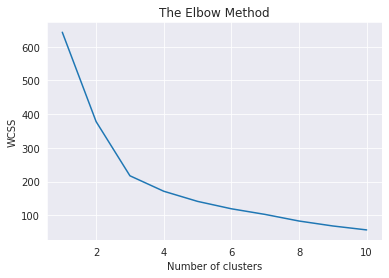

In [19]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(cs_transformed)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

Training K-means model and performing clustering.

In [20]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(cs_transformed)
y_kmeans

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0,
       0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1,
       0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 2], dtype=int32)

Visualization of clusters.

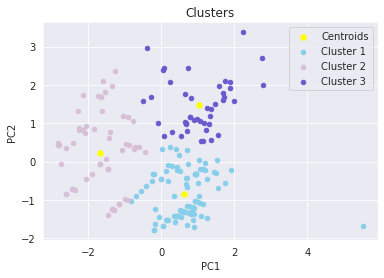

In [21]:
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')

plt.scatter(cs_transformed[y_kmeans == 0, 0], cs_transformed[y_kmeans == 0, 1], s = 20, c = 'skyblue', label = 'Cluster 1')
plt.scatter(cs_transformed[y_kmeans == 1, 0], cs_transformed[y_kmeans == 1, 1], s = 20, c = 'thistle', label = 'Cluster 2')
plt.scatter(cs_transformed[y_kmeans == 2, 0], cs_transformed[y_kmeans == 2, 1], s = 20, c = 'slateblue', label = 'Cluster 3')

plt.title("Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

###Hierarchical clustering

Building a dendrogram to find the optimal amount of clusters. The longest vertical line, that can't be crossed horizontally, will establish the threshold at the level of 3 clusters.

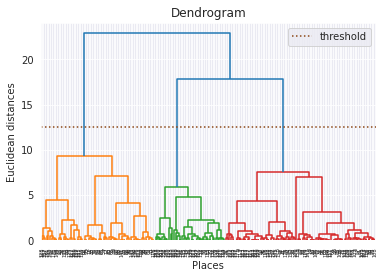

In [22]:
sch.dendrogram(sch.linkage(cs_transformed, method = 'ward'))
plt.axhline(y = 12.5, color = 'saddlebrown', linestyle = ':', label = 'threshold')
plt.title("Dendrogram")
plt.xlabel("Places")
plt.ylabel("Euclidean distances")
plt.legend(loc="upper right")
plt.show()

Training and applying Hierarchical Clustering.

In [23]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward")
y_hc = hc.fit_predict(cs_transformed)

In [24]:
y_hc

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1,
       0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2])

Clusters visualization and comparison.

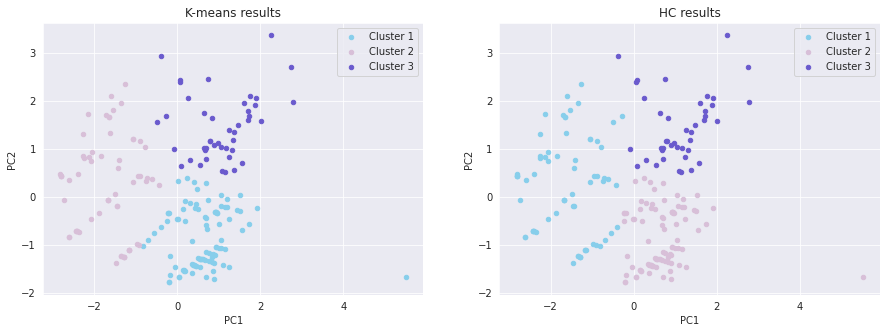

In [25]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.scatter(cs_transformed[y_kmeans == 0, 0], cs_transformed[y_kmeans == 0, 1], s = 20, c = 'skyblue', label = 'Cluster 1')
plt.scatter(cs_transformed[y_kmeans == 1, 0], cs_transformed[y_kmeans == 1, 1], s = 20, c = 'thistle', label = 'Cluster 2')
plt.scatter(cs_transformed[y_kmeans == 2, 0], cs_transformed[y_kmeans == 2, 1], s = 20, c = 'slateblue', label = 'Cluster 3')
plt.title("K-means results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(cs_transformed[y_hc == 0, 0], cs_transformed[y_hc == 0, 1], s = 20, c = 'skyblue', label = 'Cluster 1')
plt.scatter(cs_transformed[y_hc == 1, 0], cs_transformed[y_hc == 1, 1], s = 20, c = 'thistle', label = 'Cluster 2')
plt.scatter(cs_transformed[y_hc == 2, 0], cs_transformed[y_hc == 2, 1], s = 20, c = 'slateblue', label = 'Cluster 3')
plt.title("HC results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.show()

It's easy to notice, that data points got clustered almost identically.

Result vectors:

In [26]:
print(np.concatenate((y_kmeans.reshape(len(y_kmeans),1), y_hc.reshape(len(y_hc),1)),1))

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [2 2]
 [2 2]
 [2 2]
 [0 0]
 [2 2]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [2 2]
 [0 1]
 [0 1]
 [2 2]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [2 2]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [2 2]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [2 2]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [2 2]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [2 2]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [2 2]
 [2 2]
 [0 1]
 [2 0]
 [2 2]
 [0 1]
 [2 2]
 [2 0]
 [1 0]
 [2 2]
 [2 2]
 [1 0]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [0 1]
 [2 2]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

It's noticeable, that elements from K-means' zero cluster are in the HC's first cluster. I'm going to change that for measuring the accuracy.

In [27]:
y_hc_adjusted = y_hc
y_hc_adjusted[y_hc_adjusted == 0] = 9
y_hc_adjusted[y_hc_adjusted == 1] = 0
y_hc_adjusted[y_hc_adjusted == 9] = 1
y_hc_adjusted

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0,
       1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1,
       0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 2])

Making the confusion matrix and counting accuracy score.

Both models gave almost identical results, with only a 3% of difference.

In [28]:
cm = confusion_matrix(y_kmeans, y_hc_adjusted)
print(cm)
accuracy_score(y_kmeans, y_hc_adjusted)

[[90  4  0]
 [ 0 62  0]
 [ 0  2 42]]


0.97

##Results interpretation

I decided to continue with K-means clusters. Adding cluster column to the data frame, in order to make results interpretation easier.

In [29]:
coffee_shops.insert(0, "Cluster", y_kmeans)
coffee_shops

,Cluster,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,1,Mariupol,Coffee store,4.6,206.0,1,0,0,0
1,1,Mariupol,Cafe,5.0,24.0,1,0,0,1
2,1,Mariupol,Coffee shop,5.0,11.0,1,0,0,1
3,0,Mariupol,Coffee shop,4.4,331.0,1,0,1,1
4,0,Mariupol,Coffee shop,5.0,12.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...
195,2,Dnipro,Restaurant,4.6,963.0,2,0,1,1
196,2,Dnipro,Cafe,4.3,646.0,1,0,1,1
197,2,Dnipro,Cafe,4.6,16.0,1,0,1,1
198,0,Dnipro,Coffee shop,4.7,599.0,1,0,1,1


Making a catplot of the **amount** of places with a certain **average rating**, divided by cluster.

Cluster 1 is distributed from 4.3 and higher, while the others have peak around 4.6 - 4.7 and have normal distribution throughout data range.

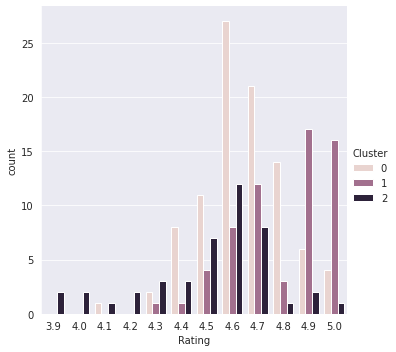

In [30]:
sns.catplot(data = coffee_shops, x = 'Rating', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

Swarmplot below shows **rating** values by **regions**.

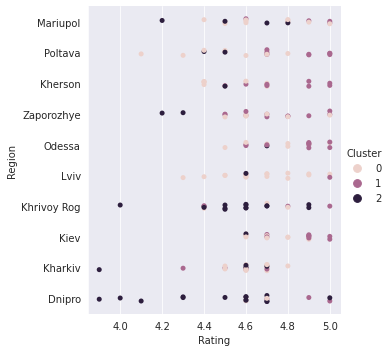

In [33]:
sns.catplot(data = coffee_shops, y = 'Region', x = 'Rating', hue = 'Cluster', palette = sns.cubehelix_palette(3))

Below there is a plot of the **number** of places **by region** for each cluster.

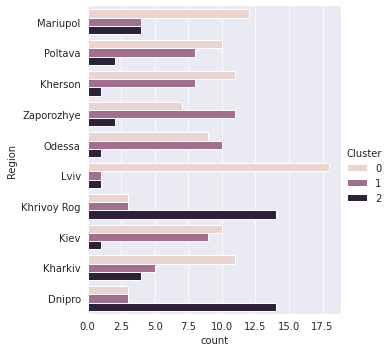

In [31]:
sns.catplot(data = coffee_shops, y = 'Region', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

Plotting the **amount** of particular place types (for values that occur more than once).

It stands out that the majority of *Cluster 0* data pieces are coffee shops, while the majority of *Cluster 2* are cafés.

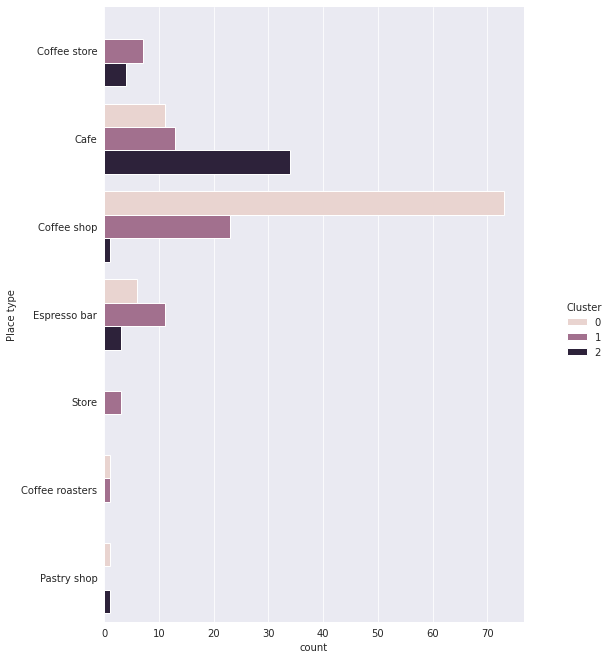

In [32]:
major_list = places_amount[places_amount.values > 1].index
catp = sns.catplot(data = coffee_shops[coffee_shops['Place type'].isin(major_list)], y = 'Place type', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))
catp.fig.set_figwidth(10)
catp.fig.set_figheight(10)

For building a swarmplot of **ratings & reviews**, I decided to check the distribution of reviews amount first.

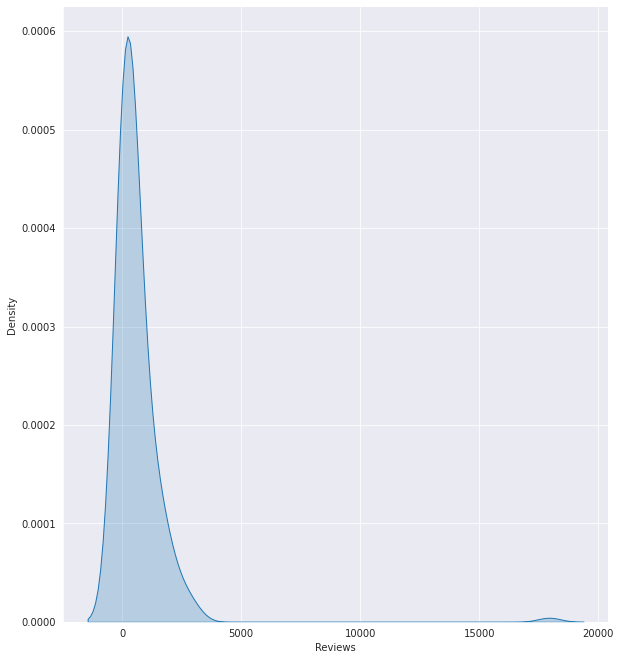

In [34]:
disp = sns.displot(data = coffee_shops, x = "Reviews", kind = "kde", fill = True)
disp.fig.set_figwidth(10)
disp.fig.set_figheight(10)

There is only one outlier point, so it can be omitted for the visualization purpose.

In [35]:
coffee_shops.loc[coffee_shops['Reviews'] > 5000]

,Cluster,Region,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
100,0,Lviv,Coffee shop,4.7,17937.0,1,1,1,1


The vast majority of *Cluster 1* data points are characterized by high rating and low number of reviews.\
On the other hand, *Cluster 0* characterizes by various number of reviews and these higher average rating values, while *Cluster 2* covers lower values as well, and distributes just about equally on the whole plane.

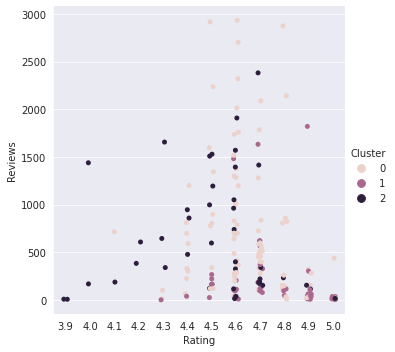

In [36]:
sns.catplot(data = coffee_shops.loc[coffee_shops['Reviews'] <= 5000], x = 'Rating', y = 'Reviews', hue='Cluster', palette = sns.cubehelix_palette(3))

Below, there is a countplot of **number** of places by the **price range**.

As was shown earlier, there are a few records with the price range different, than medium. There are exactly 6 such places, and when *Cluster 1* includes only medium price places, *Cluster 2* contains those with higher prices and *Cluster 0* with lower price range accordingly.

In [47]:
len(coffee_shops[coffee_shops.Price != 1])

6

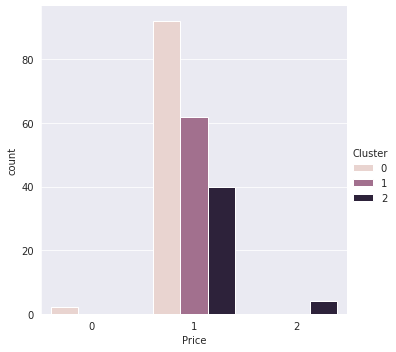

In [37]:
sns.catplot(data = coffee_shops, x = 'Price', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

Below there are plots depicting different types of services, offered by places: delivery, takeout and dine in options.

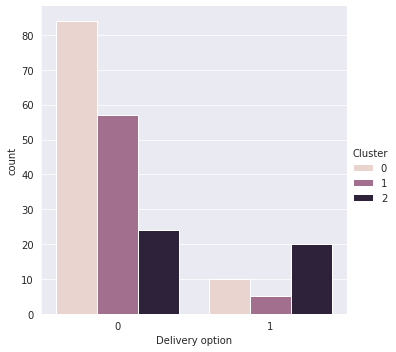

In [38]:
sns.catplot(data = coffee_shops, x = 'Delivery option', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

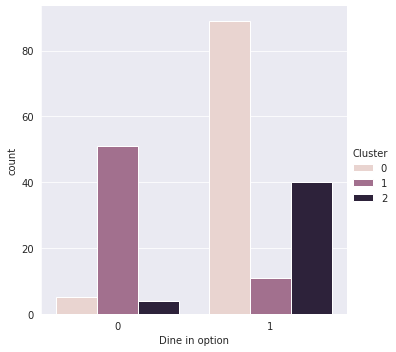

In [39]:
sns.catplot(data = coffee_shops, x = 'Dine in option', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

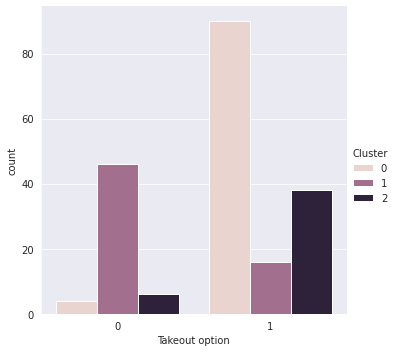

In [40]:
sns.catplot(data = coffee_shops, x = 'Takeout option', kind = 'count', hue = 'Cluster', palette = sns.cubehelix_palette(3))

*Cluster 0* - includes places with low and medium price range, high ratings, most likely a coffee shop with no delivery option.\
*Cluster 1* - places with medium prices, the highest ratings and low reviews amount.\
*Cluster 2* - includes places with higher price range, any average rating (including the lower ones), most likely a café with dine in and takeaway options.

A lot of services options had NaN values:

*Price -             78*\
*Delivery option -   71*\
*Dine in option -    60*\
*Takeout option -    56*

It influences interpretation significantly, f. ex. looking at the *Cluster 1* it can be assumed that the places don't have any services, but the reason for this is that the *False* value was assigned to the missing ones.